<a href="https://colab.research.google.com/github/tzvikif/Bananas/blob/main/BananasTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and CONSTANS


In [1]:
#from google.colab import files
#uploaded = files.upload()


In [2]:
!pip install rasterio
!pip install albumentations==0.4.6

In [3]:
# Imports
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torchvision
import os
import cv2
import glob
import pandas as pd
from skimage import io
from torch.utils.data import Dataset, DataLoader # Gives easier dataset managment and creates mini batches
import xml.etree.ElementTree as et #for xml parsing
import rasterio as rs #reads geotiff files
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt
from matplotlib import patches as patches

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


DIR_INPUT = '/content/drive/MyDrive/data/PalmTrees/Training'
#DIR_TRAIN = f'{DIR_INPUT}/Training'
#DIR_TEST = f'{DIR_INPUT}/test'

At first stage using *palm trees* datasets

In [4]:
class PalmTreesDataset(Dataset):
    def __init__(self,root_dir,transforms=None):
        self.root_dir = root_dir
        self.annotations = self.get_annotations()
        self.transforms = transforms
        self.SCHEME = '{http://tempuri.org/XMLSchema.xsd}'

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        annotated_path = os.path.join(self.root_dir,self.annotations[index])
        img_name,bboxes = self.get_annotatated_data(annotated_path)
        #print(f'** index:{index}, img_name:{img_name}')
        img_path = os.path.join(self.root_dir,img_name)
        with rs.open(img_path) as img:
            image = img.read()
            shape = image.shape
            image = np.transpose(image,(1,2,0))
            #print(f'**shape:{image.shape}')
            image = image/255
            area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.ones((bboxes.shape[0],), dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((bboxes.shape[0],), dtype=torch.int64)
            
            target = {}
            target['boxes'] = bboxes
            target['labels'] = labels
            # target['masks'] = None
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd

            if self.transforms:
                #print(f'image.shape:{image.shape:}, bboxes:{target["boxes"]}')
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                #print(f'** shape:{image.shape}')
                sample = self.transforms(**sample)
                #print(f'** after transform **:{sample["bboxes"]}')
                image = sample['image']
                
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

            return image, target, img_name

            

    def get_annotations(self):
        names = glob.glob(f'{self.root_dir}/palm*.xml')
        return names
    def get_annotatated_data(self,annotated_path):
        xtree = et.parse(annotated_path)
        xroot = xtree.getroot()
        filename_element = xroot.find(self.SCHEME+'filename')
        img_name = filename_element.text
        for element in xroot.find('./'+self.SCHEME+'size'):
            if element.tag == self.SCHEME + 'width':
                width = element.text
            if element.tag == self.SCHEME + 'height':
                height = element.text
        rows = len(xroot.findall('.//'+self.SCHEME+'bndbox'))
        bboxes = np.zeros([rows,4])
        for i,bbox in enumerate(xroot.findall('.//'+self.SCHEME+'bndbox')):
            xmin = int(bbox.find(self.SCHEME+'xmin').text)
            ymin = int(bbox.find(self.SCHEME+'ymin').text)
            xmax = int(bbox.find(self.SCHEME+'xmax').text)
            ymax = int(bbox.find(self.SCHEME+'ymax').text)
            bboxes[i,:] = xmin,ymin,xmax,ymax
        return img_name,bboxes


In [5]:
pt_dataset = PalmTreesDataset(DIR_INPUT)
image,target,image_id = pt_dataset[0]
print(f'image.shape:{image.shape}, target:{target}, image_id:{image_id}')


image.shape:(501, 445, 3), target:{'boxes': array([[ 64., 432., 180., 500.],
       [179., 242., 285., 331.]]), 'labels': tensor([1, 1]), 'image_id': tensor([0]), 'area': tensor([7888., 9434.]), 'iscrowd': tensor([0, 0])}, image_id:palm_tile0_0.img


In [6]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
def get_train_transform_tensor():
    return A.Compose([
        ToTensorV2(p=1.0)
    ],)
def get_train_transform_tensor():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])


def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Create the model

In [7]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [8]:
num_classes = 2  # 1 class (Palm) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [9]:
#model

In [10]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = PalmTreesDataset(DIR_INPUT, get_train_transform_tensor())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)
'''
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)
'''

'\nvalid_data_loader = DataLoader(\n    valid_dataset,\n    batch_size=8,\n    shuffle=False,\n    num_workers=4,\n    collate_fn=collate_fn\n)\n'

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

##Sample

In [13]:
images, targets, image_ids = next(iter(train_data_loader))
#print(f'images:{images[0].shape} targets:{targets[0].keys()} image_ids:{image_ids[0]}')
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [14]:
boxes = targets[3]['boxes'].cpu().numpy().astype(np.int32)
sample = images[3].permute(1,2,0).cpu().numpy()
print(sample.shape)

(501, 445, 3)


[189  67 267 147]
[334  42 427 135]
[139 235 216 318]
[290 204 335 258]
[262 347 353 417]
[196 389 263 439]
[400 317 444 432]
[ 61 337 121 380]


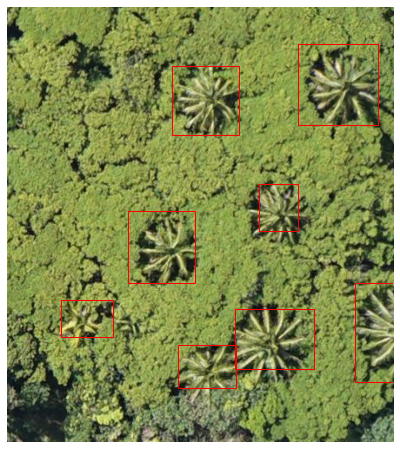

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box in boxes:
    print(box)
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor='r', facecolor="none")
    ax.add_patch(rect)    
ax.set_axis_off()
ax.imshow(sample)

##Train

In [19]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 10

In [20]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        images = list(image.to(device,dtype=torch.float) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Epoch #0 loss: 0.44002866094311743
Epoch #1 loss: 0.4058877703362773
Iteration #50 loss: 0.38668875879625525
Epoch #2 loss: 0.36920888779991173
Epoch #3 loss: 0.335690741821775
Iteration #100 loss: 0.3194223162922008
Epoch #4 loss: 0.29817664590097154
Epoch #5 loss: 0.2664167533444734
Iteration #150 loss: 0.24764801781052737
Epoch #6 loss: 0.25123767884715625
Epoch #7 loss: 0.2376736318974574
Iteration #200 loss: 0.16792514680156898
Epoch #8 loss: 0.22569884313652266
Epoch #9 loss: 0.21002558463801682
